In [66]:
import pandas as pd
# numpy allows us to do vector math and has a lot of common math functions.
import numpy as np
# matplotlib.pyplot allows us to quickly and easily plot data to visualize it.
import matplotlib.pyplot as plt

#---------------machine learning python libraries-----------------
# The train_test_split function allows us to easily split our data
from sklearn.model_selection import train_test_split
# We use these classes to setup a grid search to find optimal model parameters
from sklearn.model_selection import KFold, GridSearchCV
# StandardScalar and Normalizer are used to scale the data.
from sklearn.preprocessing import StandardScaler, Normalizer
# We will use a support vector regression (SVR) to predict our properties
from sklearn.svm import SVR
# We can get simple metrics to monitor performance
from sklearn.metrics import r2_score, mean_squared_error

#---------------custom python code-------------------------------------------
# We need to import custom python code that is to complicated for this guide.
import composition
import utils
import pickle

In [67]:
df_aflow_elastic = pd.read_csv('aflow_data/aflow_elastic_data.csv')

In [68]:
uncleaned_formulae = df_aflow_elastic['ENTRY ']

In [69]:
cleaned_formulae = []

for cell_value in uncleaned_formulae:
    split_list = cell_value.split(" [")
    clean_formula = split_list[0]
    cleaned_formulae.append(clean_formula)

In [70]:
df_cleaned = pd.DataFrame()
df_cleaned['formula'] = cleaned_formulae
df_cleaned['bulk_modulus'] = df_aflow_elastic['AEL VRH bulk modulus ']

In [71]:
check_for_duplicates = df_cleaned['formula'].value_counts()
df_cleaned.drop_duplicates('formula', keep='first', inplace=True)

[]

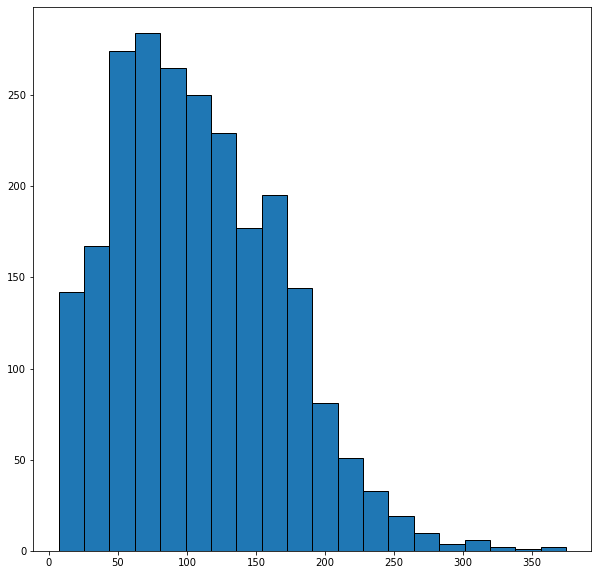

In [72]:
plt.figure(1, figsize=(10, 10))
df_cleaned['bulk_modulus'].hist(bins=20, grid=False, edgecolor='black')
plt.plot()

In [73]:
df_cleaned.columns = ['formula', 'target']

In [74]:
X, y, formulae = composition.generate_features(df_cleaned)

The element: Pu from formula C8Pu4W4 is not currently supported in our database


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)



In [76]:
scalar = StandardScaler()
normalizer = Normalizer()

In [77]:
X_train_scaled = scalar.fit_transform(X_train)  
X_test_scaled = scalar.transform(X_test)  
X_train_scaled = normalizer.fit_transform(X_train_scaled)  
X_test_scaled = normalizer.transform(X_test_scaled)  

In [78]:
model = SVR()

In [79]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)
c_parameters = np.logspace(-1, 3, 5)
gamma_parameters = np.logspace(-2, 2, 5)

parameter_candidates = {'C': c_parameters,
                        'gamma': gamma_parameters}

grid = GridSearchCV(estimator=model,
                    param_grid=parameter_candidates,
                    cv=cv)
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=SVR(),
             param_grid={'C': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])})

{'C': 100.0, 'gamma': 1.0}


[]

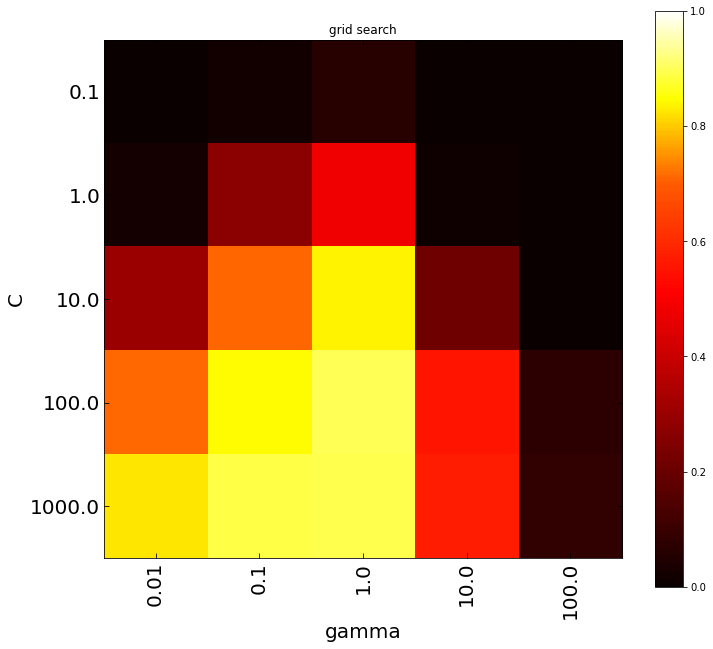

In [80]:
best_parameters = grid.best_params_
print(best_parameters)
utils.plot_2d_grid_search(grid, midpoint=0.7, vmin=-0, vmax=1)
plt.plot()

r2 score: 0.919, rmse: 17.09


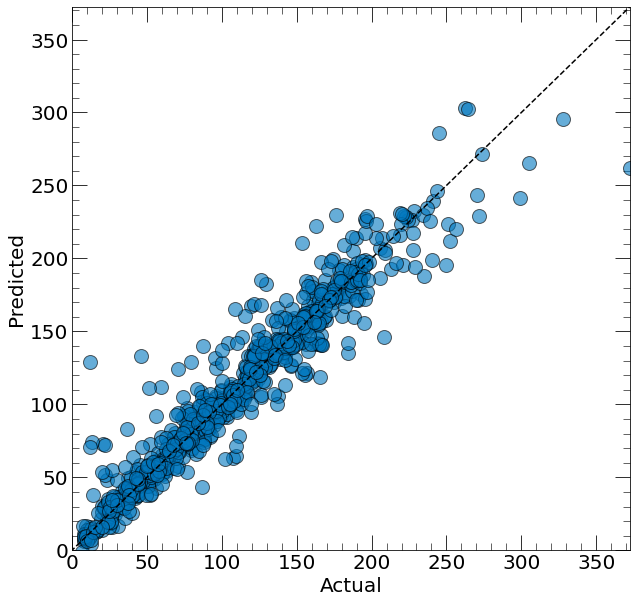

In [81]:
# make our final model using the "best_parameters" dictionary as our arguments.
final_model = SVR(**best_parameters)

# fit the model to the training data
final_model.fit(X_train_scaled, y_train)

# predict on the test data
y_test_predicted = final_model.predict(X_test_scaled)

# plot the results to see how we did
utils.plot_act_vs_pred(y_test, y_test_predicted)
score = r2_score(y_test, y_test_predicted)
rmse = np.sqrt(mean_squared_error(y_test, y_test_predicted))

print('r2 score: {:0.3f}, rmse: {:0.2f}'.format(score, rmse))


In [82]:
import pickle 
pickle_out = open("classifier.pkl", mode = "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()

In [84]:
class MaterialsModel():
    def __init__(self, trained_model, scalar, normalizer):
        self.model = trained_model
        self.scalar = scalar
        self.normalizer = normalizer

    def predict(self, formula):
        '''
        Parameters
        ----------
        formula: str or list of strings
            input chemical formula or list of formulae you want predictions for
    
        Return
        ----------
        prediction: pd.DataFrame()
            predicted values generated from the given data
        '''
        # Store our formula in a dataframe. Give dummy 'taget value'.
        # (we will use composition.generate_features() to get the features)
        if type(formula) is str:
            df_formula = pd.DataFrame()
            df_formula['formula'] = [formula]
            df_formula['target'] = [0]
        if type(formula) is list:
            df_formula = pd.DataFrame()
            df_formula['formula'] = formula
            df_formula['target'] = np.zeros(len(formula))
        # here we get the features associated with the formula
        X, y, formula = composition.generate_features(df_formula)
        # here we scale the data (acording to the training set statistics)
        X_scaled = self.scalar.transform(X)
        X_scaled = self.normalizer.transform(X_scaled)
        y_predicted = self.model.predict(X_scaled)
        # save our predictions to a dataframe
        prediction = pd.DataFrame(formula)
        prediction['predicted value'] = y_predicted
        return prediction

# initialize an object to hold our bulk modulus model
bulk_modulus_model = MaterialsModel(final_model, scalar, normalizer)
formulae_to_predict = ['AgNO3']
# use the bulk modulus object to generate predictions for our formulae!
bulk_modulus_prediction = bulk_modulus_model.predict(formulae_to_predict)

bulk_modulus_prediction

,formula,predicted value
0,AgNO3,119.73773
